In [61]:
import sys
sys.path.append('../')
sys.path.append('../model')
import logging
from glob import glob
import numpy as np

from scipy.integrate import simpson, quad, trapezoid, cumulative_trapezoid
from scipy.signal import boxcar, convolve

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import pandas as pd

from astropy.table import Table
import astropy.units as u
from astropy.io import fits

from uvot import filters, filter_colors, filter_cent, filter_fwhm, filter_rsp
from xrt import curves

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

```
1 Angstrom (A) corresponds to 12398 eV (or 12.398 keV)
10 Angstroms = 12.398 / 10 = 1.2398 keV
1 keV corresponds to 12.398425 A
```

The inclination bins correspond to:

```
bin1 = 5.7  - 22.5 (cent = 14.10)
bin2 = 22.5 - 45   (cent = 33.75)
bin3 = 45   - 67.5 (cent = 67.50)
bin4 = 67.5 - 87.4 (cent = 77.45)
```

The simplest method is for a given inclination to see which bin it falls into.
However if we wish to evalulate for a specific inclination, we will probably have
to perform some sort of interpolation. This can be done by assuming each spectra
corresponds to the center of the bin and interpolating manually.

We calculate the emission in a given band, first assuming a flat detector response
to obtain the expected intrinsic emission then we convolve with the swift detector
response in each bands, (xrt + uv) to obtain what the predicted flux would be.

We then calculate the relative emission between two bands by divinding the emission in band 1
by the emission in band 2.

Since the spectra obtained is created for a TDE with a supermassive black hole
we employ a scaling relation where we assume the highest inclination Temperature for
the blackbody in jane's simulations corresponds to the photosphere temperature given in
Poutanan 2007.
We need to remember however that there will be a factor that scales T to the peak of the black body found
from differentiating Plank's function



i(t) --> F(t) 

In [2]:
i_cent = {1 : 14.10,
          2 : 33.75,
          3 : 67.50,
          4 : 77.45}

In [3]:
def get_inclination_bin(i):
    if (i >= 5.7) and  (i < 22.5):
        bin = 1
    elif (i >= 22.5) and (i < 45):
        bin = 2
    elif (i >= 45) and  (i < 67.5):
        bin = 3
    elif (i >= 67.5) and  (i < 87.4):
        bin = 4
    else:
        raise ValueError(f'inclination i={i} does not fall into a valid bin') 
    logging.info(f'inclination i={i} bin_number = {bin}')
    return bin

In [4]:
def read_lixdai_spec(bin_num):
    df = pd.read_csv(f'../external/lixin_dai_spectra/bin{bin_num}.txt', sep='\s+', header=None, names=['lambda','flux'])
    df['energy'] = 12.398 / df['lambda']
    df = df.sort_values('energy', ascending=True)   # Sort dataframe by Increasing energy
    return df

In [5]:
def get_flux_ratio(i, band1, band2):
    """
    Calculate the flux ratio between two bands.
    
    i : inclination in degrees
    band1, band2 : one of: ['FULL, SOFT, HARD, ... uvot bands']
    """

In [6]:
def get_band_instrument(band):
    if band in curves:
        inst = 'XRT'
    elif band in filters:
        inst = 'UVOT'
    else:
        raise KeyError(f'band={band} is neither in XRT or UVOT')
    logging.info(f'band={band} inst={inst}')
    return inst



In [8]:
def get_response(band, flat_response=True):
    inst = get_band_instrument(band)
    if flat_response:
        if inst == 'XRT':
            
        elif inst == 'UVOT':
            
    elif not flat_response:
        if inst == 'XRT':
            rmf_pc = Table.read('../external/swift_rsp/swxpc0to12s6_20130101v014.rmf')
            
        

IndentationError: expected an indented block (814640383.py, line 6)

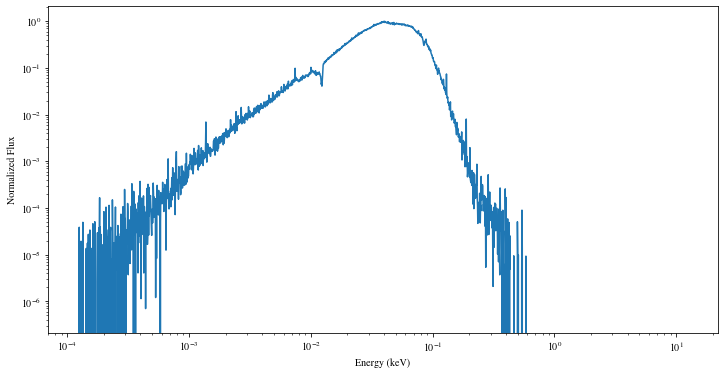

In [9]:
i = 7
flat_response = False
band1 = 'PC'
band2 = 'UVW1'

bin_num = get_inclination_bin(i)
df = read_lixdai_spec(bin_num)

#df_band1 = get_response(band1, flat_response)
#df_band2 = get_response(band2, flat_response)

df_band1 = (df['energy'] >= 1.5) & (df['energy'] <= 10.0)
df_band2 = (df['energy'] >= 1.5) & (df['energy'] <= 10.0)

int1 = simpson(df['flux'], x=df['energy'])
int2 = trapezoid(df['flux'], x=df['energy'])

# Plot Spectrum
plt.figure(figsize=(12,6))
plt.loglog(df['energy'], df['flux'])
plt.xlabel('Energy (keV)')
plt.ylabel('Normalized Flux')
plt.show()

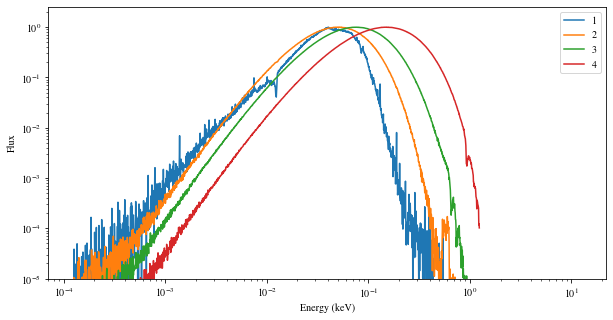

In [10]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

for n in [1,2,3,4]:
    df = read_lixdai_spec(bin_num=n)
    ax.plot(df['energy'], df['flux'], label=n)
    ax.loglog()
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('Flux')
ax.set_ylim(1e-5)
ax.legend()

In [12]:
# Shifting the spectra
#
# take the most edge on spectra and scale them so that the peak temp is at T_ph from Potanen 2007

THETA = 20 * (np.pi/180)    # FULL OPENING ANGLE                                   
ZETA = 1 / np.tan(THETA)    # cot(theta)                                      
BETA = 1                                                                       
EPSILON_WIND = 0.5          # fraction of radiative energy accelerate the outflow       
MASS = 10                                                                       

def T_sp(mdot_0):                                              
    return 1.5*MASS**-0.25*mdot_0**-0.5 * (1+0.3*mdot_0**-0.75)

def T_ph(mdot_0):                                                                 
    """units of keV"""                                                            
    return 0.8 * ((ZETA * BETA) / EPSILON_WIND)**0.5 * MASS**-0.25 * mdot_0**-0.75 

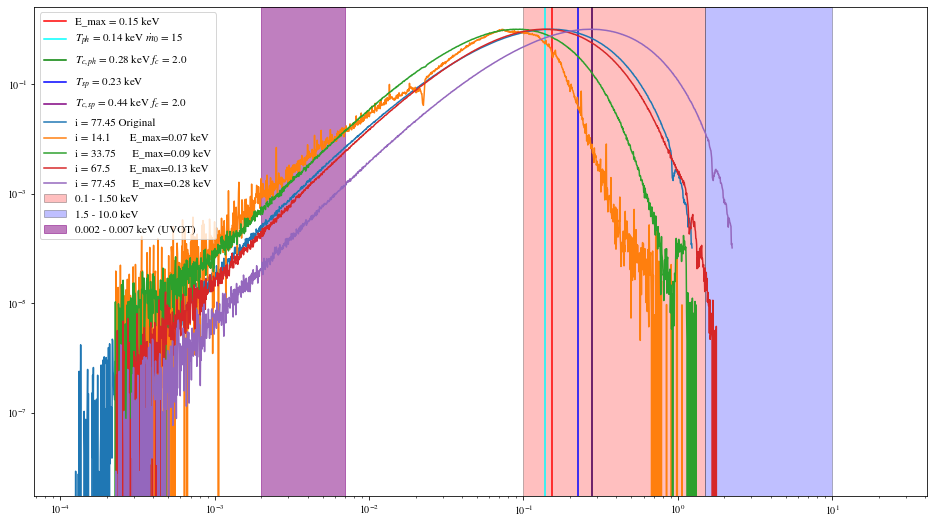

In [59]:
mdot_0 = 15

df = read_lixdai_spec(bin_num=4)
idx = df['flux'].argmax()
E_max = df.iloc[idx]['energy']


# Color temperature at the Spherization Radius
f_c    = 2.0 # Color temperature factor
T_c_sp = 1.5 * f_c * MASS**-0.25 * mdot_0**-0.5
T_c_ph = f_c * T_ph(mdot_0)

scaling_factor = T_c_ph / E_max

plt.figure(figsize=(16,9), facecolor='white')
plt.axvline(E_max, color='red', label=f'E_max = {E_max:.2f} keV')
plt.axvline(T_ph(mdot_0), color='cyan', label=f'$T_{{ph}}$ = {T_ph(mdot_0):.2f} keV $\dot{{m}}_0$ = {mdot_0}')
plt.axvline(T_c_ph, color='green', label=f'$T_{{c,ph}}$ = {T_c_ph:.2f} keV $f_c$ = {f_c}')

plt.axvline(T_sp(mdot_0), color='blue', label=f'$T_{{sp}}$ = {T_sp(mdot_0):.2f} keV ')
plt.axvline(T_c_ph, color='purple', label=f'$T_{{c,sp}}$ = {T_c_sp:.2f} keV $f_c$ = {f_c}')

plt.loglog(df['energy'], df['flux'], label=f'i = {i_cent[4]} Original')

for n in [1,2,3,4]:
    df = read_lixdai_spec(bin_num=n)
    df['energy_scaled'] = df['energy'] * scaling_factor
    idx = df['flux'].argmax()
    E_max = df.iloc[idx]['energy_scaled']
    
    plt.loglog(df['energy_scaled'], df['flux'], label=f'i = {i_cent[n]:<10} E_max={E_max:.2f} keV')


plt.axvspan(0.1,1.5, label='0.1 - 1.50 keV', color='red', alpha=0.25, ec='black')
plt.axvspan(1.5,10.0, label='1.5 - 10.0 keV', color='blue', alpha=0.25, ec='black')
plt.axvspan(0.002, 0.007, label='0.002 - 0.007 keV (UVOT)', color='purple', alpha=0.5)

plt.legend(loc='upper left', prop={'size': 11})

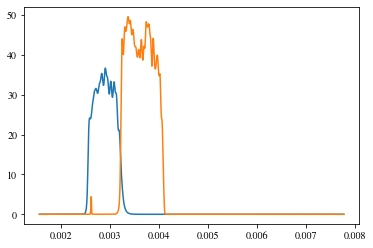

In [69]:
plt.plot(filter_rsp['B']['ENERG_HI'], filter_rsp['B']['MATRIX'])
plt.plot(filter_rsp['U']['ENERG_HI'], filter_rsp['U']['MATRIX'])


In [108]:
E_rsp  = np.array(filter_rsp['U']['ENERG_HI'])
M_rsp  = np.array(filter_rsp['U']['MATRIX'])

E_spec = np.array(df['energy_scaled'])
F_spec = np.array(df['flux'])


Response Info
E_min=0.0015 E_max=0.0078 len = 1282
Spectra Info
E_min=0.0002 E_max=2.2492 len = 1600
Interpolating Response over n = 2000 datapoints
integrating band spectrum
8.676283209518675e-06


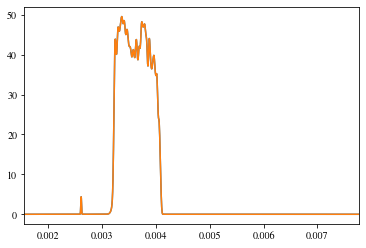

In [109]:
print('Response Info')
print(f'E_min={min(E_rsp):.4f} E_max={max(E_rsp):.4f} len = {len(E_rsp)}')
                                                     
print('Spectra Info')
print(f'E_min={min(E_spec):.4f} E_max={max(E_spec):.4f} len = {len(E_spec)}')

# We only need to create a grid of x values over the response range
n_interp = 2000
E_lo = min(E_rsp)
E_hi = max(E_rsp)
E_interp = np.linspace(E_lo, E_hi, n_interp)

print(f'Interpolating Response over n = {n_interp} datapoints')
f_interp_rsp = interpolate.interp1d(E_rsp, M_rsp)
f_interp_spec = interpolate.interp1d(E_spec, F_spec)

M_rsp_interp  = f_interp_rsp(E_interp)
F_spec_interp = f_interp_spec(E_interp)

F_spec_band = M_rsp_interp * F_spec_interp

plt.plot(E_interp, M_rsp_interp)
plt.plot(E_interp, M_rsp_interp)

#plt.plot(E_interp, F_spec_band)
#plt.plot(E_interp, F_spec_interp)
#plt.plot(E_spec, F_spec)
plt.xlim(E_lo, E_hi)
#plt.ylim(0,0.01)

print('integrating band spectrum')
int1 = trapezoid(y=F_spec_win, x=E_interp)
print(int1)


In [115]:

df1 = read_lixdai_spec(1)
df2 = read_lixdai_spec(2)
df3 = read_lixdai_spec(3)
df4 = read_lixdai_spec(4)

#np.ndarray()

array([1.24336847e-04, 1.25054216e-04, 1.25776082e-04, ...,
       1.22207984e+01, 1.22910677e+01, 1.23621498e+01])

In [129]:
np.ndarray(shape=(4,1))

array([[  7.325     ],
       [187.46261578],
       [ 17.2       ],
       [197.10324078]])

In [153]:
for df in [df1,df2,df3,df4]:
    print(df['energy'].max())

12.362149765679531
1.2362149765679529
1.2362149765679529
1.2362149765679529


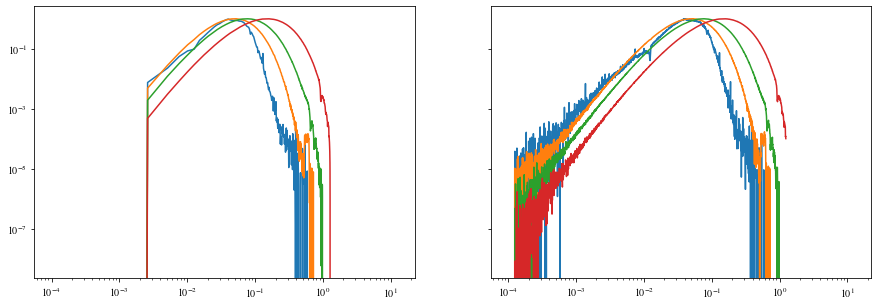

In [160]:
f1 = interpolate.interp1d(df1['energy'], df1['flux'], fill_value='extrapolate')
f2 = interpolate.interp1d(df2['energy'], df2['flux'], fill_value='extrapolate')
f3 = interpolate.interp1d(df3['energy'], df3['flux'], fill_value='extrapolate')
f4 = interpolate.interp1d(df4['energy'], df4['flux'], fill_value='extrapolate')

x_interp = np.linspace(0.00010,12.5,5000)

F1 = f1(x_interp)
F2 = f2(x_interp)
F3 = f3(x_interp)
F4 = f4(x_interp)


fig, ax = plt.subplots(1,2,figsize=(15,5), sharex=True, sharey=True)
ax[0].loglog(x_interp, F1)
ax[0].loglog(x_interp, F2)
ax[0].loglog(x_interp, F3)
ax[0].loglog(x_interp, F4)
ax[1].loglog(df1['energy'], df1['flux'])
ax[1].loglog(df2['energy'], df2['flux'])
ax[1].loglog(df3['energy'], df3['flux'])
ax[1].loglog(df4['energy'], df4['flux'])





In [110]:
?interpolate.griddata

Signature:
interpolate.griddata(
    points,
    values,
    xi,
    method='linear',
    fill_value=nan,
    rescale=False,
)
Docstring:
Interpolate unstructured D-D data.

Parameters
----------
points : 2-D ndarray of floats with shape (n, D), or length D tuple of 1-D ndarrays with shape (n,).
    Data point coordinates.
values : ndarray of float or complex, shape (n,)
    Data values.
xi : 2-D ndarray of floats with shape (m, D), or length D tuple of ndarrays broadcastable to the same shape.
    Points at which to interpolate data.
method : {'linear', 'nearest', 'cubic'}, optional
    Method of interpolation. One of

    ``nearest``
      return the value at the data point closest to
      the point of interpolation. See `NearestNDInterpolator` for
      more details.

    ``linear``
      tessellate the input point set to N-D
      simplices, and interpolate linearly on each simplex. See
      `LinearNDInterpolator` for more details.

    ``cubic`` (1-D)
      return the value dete

0.03138037831962561
0.06289506536696646
0.1289473044721926
0.27650923043222564


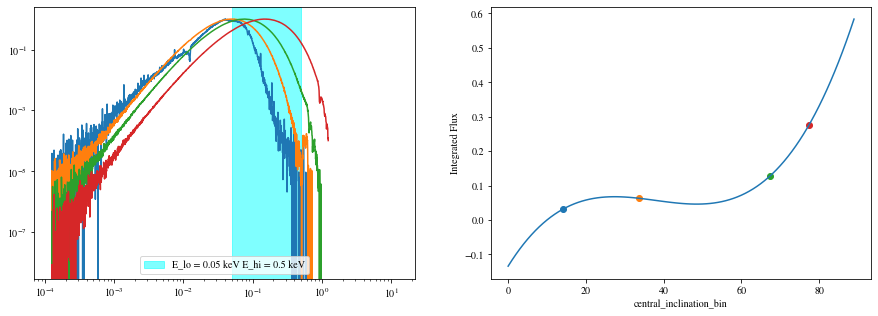

In [58]:
band_lo = 0.05
band_hi = 0.5
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].axvspan(band_lo, band_hi, alpha=0.5, color='cyan', label=f'E_lo = {band_lo} keV E_hi = {band_hi} keV')
ax[0].legend()

inclinations = []
fluxes = []

for n in [1,2,3,4]:
    df = read_lixdai_spec(bin_num=n)

    sub = df[(df['energy'] >= band_lo) & (df['energy'] < band_hi)]
    int1 = trapezoid(sub['flux'], x=sub['energy'])
    print(int1)
    
    inclinations.append(i_cent[n])
    fluxes.append(int1)
        
    ax[0].loglog(df['energy'], df['flux'])
    ax[1].scatter(i_cent[n], int1)
ax[1].set_xlabel('central_inclination_bin')
ax[1].set_ylabel('Integrated Flux')

#ck = interpolate.splrep(inclinations, fluxes, s=0)
f = interpolate.interp1d(inclinations, fluxes, kind='cubic', fill_value='extrapolate')
xnew = np.arange(0, 90, 1)
ynew = f(xnew)
ax[1].plot(xnew, ynew)


In [16]:
# UVOT responses
rsp_v      = Table.read('/mnt/d/anticorr_data/external/swift_rsp/v.rsp')
rsp_b      = Table.read('/mnt/d/anticorr_data/external/swift_rsp/b.rsp')
rsp_u      = Table.read('/mnt/d/anticorr_data/external/swift_rsp/u.rsp')
rsp_uvw1   = Table.read('/mnt/d/anticorr_data/external/swift_rsp/uvw1.rsp')
rsp_uvm2   = Table.read('/mnt/d/anticorr_data/external/swift_rsp/uvm2.rsp')
rsp_uvw2   = Table.read('/mnt/d/anticorr_data/external/swift_rsp/uvw2.rsp')
rsp_ugrism = Table.read('/mnt/d/anticorr_data/external/swift_rsp/ugrism.rsp')
rsp_vgrism = Table.read('/mnt/d/anticorr_data/external/swift_rsp/vgrism.rsp')
rsp_white  = Table.read('/mnt/d/anticorr_data/external/swift_rsp/white.rsp')

# XRT responses
rmf_wt = Table.read('../external/swift_rsp/swxwt0to2s6_20131212v015.rmf')
rmf_pc = Table.read('../external/swift_rsp/swxpc0to12s6_20130101v014.rmf')


all_rsp = {'V'      : rsp_v,
           'B'      : rsp_b,
           'U'      : rsp_u,
           'UVW1'   : rsp_uvw1,
           'UVM2'   : rsp_uvm2,
           'UVW2'   : rsp_uvw2,
           'WHITE'  : rsp_white,
           'ugrism' : rsp_ugrism,
           'vgrism' : rsp_vgrism}

In [17]:
def a2kev(a):
    return 12.398425 / a

def kev2a(kev):
    return 12.398425 / kev

In [18]:
12.398425 / 0.004492184

2759.999367790812

V
B
U
UVW1
UVM2
UVW2
WHITE


/tmp/ipykernel_1087/654635484.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return 12.398425 / a
/tmp/ipykernel_1087/654635484.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return 12.398425 / a


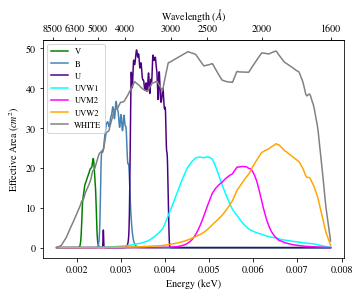

In [19]:
fig, ax = plt.subplots(1,1, figsize=(5.4,4))
for filt, tab in all_rsp.items():
    if 'grism' in filt:
        continue
    print(filt)
    tab['ANGSTROM'] = 12.398425 * tab['ENERG_LO']
    ax.plot(tab['ENERG_LO'], tab['MATRIX'], label=filt, color=filter_colors[filt])

    
secax = ax.secondary_xaxis('top', functions=(kev2a, a2kev))
secax.set_xlabel(r'Wavelength $(\AA)$')
secax.set_xticks([1600,2000,2500,3000,4000,5000, 6300, 8500])

ax.set_xlabel('Energy (keV)')
ax.set_ylabel('Effective Area ($cm^2$)')
ax.legend(loc='upper left', prop={'size': 8.5})

plt.savefig('../figures/UVOT_effective_areas.png')
plt.savefig('../figures/UVOT_effective_areas.pdf')

In [20]:
rmf_pc

ENERG_LO,ENERG_HI,N_GRP,F_CHAN,N_CHAN,MATRIX [1024]
keV,keV,,,,
float32,float32,int16,int16,int16,float32
0.0,0.005,1,0,1024,0.0 .. 0.0
0.005,0.01,1,0,1024,0.0 .. 0.0
0.01,0.015,1,0,1024,0.0 .. 0.0
0.015,0.02,1,0,1024,0.0 .. 0.0
0.02,0.025,1,0,1024,0.0 .. 0.0
0.025,0.03,1,0,1024,0.0 .. 0.0
0.03,0.035,1,0,1024,0.0 .. 0.0
0.035,0.04,1,0,1024,0.0 .. 0.0


In [21]:
rmf_pc['MATRIX_MEAN'] = np.mean(rmf_pc['MATRIX'].value, axis=1)

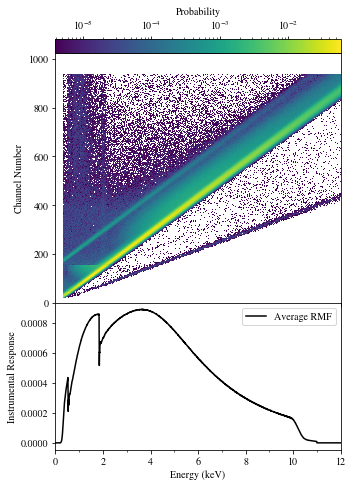

In [22]:
fig, ax = plt.subplots(2,1, figsize=(5,7), gridspec_kw={'height_ratios':[2,1]}, sharex=True)
rmf = rmf_pc['MATRIX'].value

im = ax[0].imshow(rmf, norm=LogNorm(), interpolation='none', extent=[0,12,0,1024], aspect='auto', origin='lower')

#ax[0].set_xlabel('Energy (keV)')
ax[0].set_ylabel('Channel Number')
cbar = plt.colorbar(im, ax=ax[0], orientation="horizontal", pad=0.0, location='top')
cbar.ax.set_xlabel('Probability')

ax[1].plot(rmf_pc['ENERG_LO'], rmf_pc['MATRIX_MEAN'], color='black', label='Average RMF')
#ax[1].set_title('SWIFT XRT AVERAGED RMF')
ax[1].set_xlabel('Energy (keV)')
ax[1].set_ylabel('Instrumental Response')
ax[1].set_xticks([0,2,4,6,8,10,12])
ax[1].xaxis.set_minor_locator(plt.MultipleLocator(1))
ax[1].legend()
plt.tight_layout()
plt.subplots_adjust(hspace=0)

plt.savefig('../figures/daispec/XRT_RMF_averaged.png', facecolor='white')
plt.savefig('../figures/daispec/XRT_RMF_averaged.pdf')

In [ ]:
rmf

V
B
U
UVW1
UVM2
UVW2
WHITE


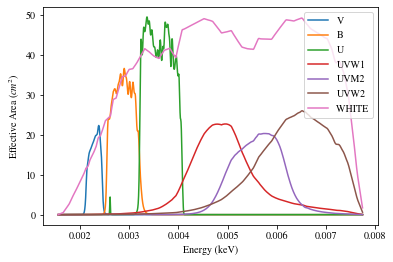

In [23]:
for filt, tab in all_rsp.items():
    if 'grism' in filt:
        continue
    print(filt)
    plt.plot(tab['ENERG_LO'], tab['MATRIX'], label=filt)
    
#plt.plot(rmf_pc['ENERG_LO'], rmf_pc['MATRIX_MEAN'], color='black', label='Average RMF')
    
plt.xlabel('Energy (keV)')
plt.ylabel('Effective Area ($cm^2$)')
plt.legend()
plt.savefig('../figures/daispec/uvot_transmission.png', facecolor='white')
plt.savefig('../figures/daispec/uvot_transmission.pdf')

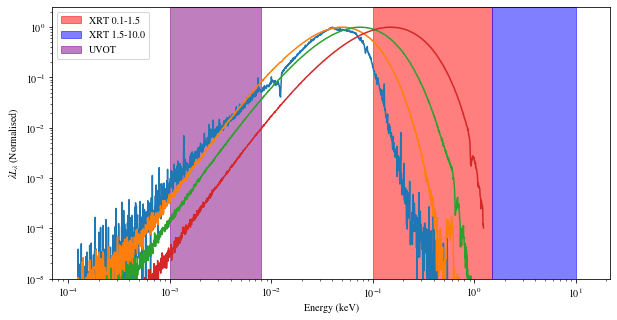

In [24]:
files = glob('../external/lixin_dai_spectra/*.txt')
fig, ax = plt.subplots(1,1, figsize=(10,5))

for f in files:
    df = pd.read_csv(f, sep='\s+', header=None)
    df['Energy'] = 12.398 / df[0]
    ax.plot(df['Energy'], df[1])
    ax.loglog()
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('$\lambda L_{\lambda}$ (Normalised)')
ax.set_ylim(1e-5)

ax.axvspan(0.1, 1.5, alpha=0.5, color='red', label='XRT 0.1-1.5')
ax.axvspan(1.5, 10.0, alpha=0.5, color='blue', label='XRT 1.5-10.0')
ax.axvspan(0.001, 0.008, alpha=0.5, color='purple', label='UVOT')
ax.legend()
plt.savefig('../figures/daispec/spectrum_w_bands_energy_space.png', facecolor='white')
plt.savefig('../figures/daispec/spectrum_w_bands_energy_space.pdf')

In [25]:
#fits.open('../external/swift_rsp/swxpc0to12s6_20130101v014.rmf')[1].header

In [26]:
L = np.array([1,1,1])
O = np.array([0,1,0])
z = np.array([0,0,1])


# Precessional angle
del_i = 5 * (np.pi / 180)

# Period
P = 1

# Observer Position
x1 = 0
y1 = 0
z1 = 1

# Observer / z angle
# i_2 = np.arccos(o.z / |z|*|o|)
# i_2 = np.arccos((x1*)
i2 = np.arccos(np.dot(L,z) / np.linalg.norm(L) * np.linalg.norm(z))

In [27]:
np.rad2deg(i2)

54.735610317245346

In [28]:
def i(t):
    a = (x1*np.tan(del_i)*np.cos(2*np.pi*t/P) + y1*np.tan(del_i)*np.sin(2*np.pi*t/P) + z1)
    b = np.sqrt(np.tan(del_i)**2*np.cos(2*np.pi*t/P)**2+np.tan(del_i)**2*np.sin(2*np.pi*t/P)**2+1) * np.sqrt(x1**2+y1**2+z1**2)
    i = np.arccos(a / b)
    return i

In [29]:
ts = np.linspace(0,5,1000)

Text(0, 0.5, 'Inclination')

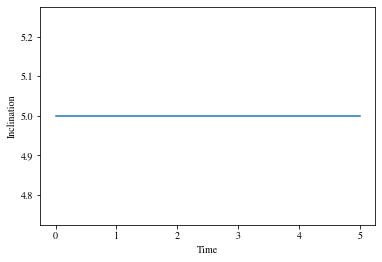

In [30]:
import matplotlib.pyplot as plt
plt.plot(ts, np.rad2deg(i(ts)))
plt.xlabel('Time')
plt.ylabel('Inclination')

In [31]:
df

,0,1,Energy
0,10.029,1.017787e-04,1.236215
1,10.087,1.227714e-04,1.229107
2,10.145,1.173108e-04,1.222080
3,10.204,2.517111e-04,1.215014
4,10.262,2.643834e-04,1.208147
...,...,...,...
1595,97443.000,0.000000e+00,0.000127
1596,98006.000,0.000000e+00,0.000127
1597,98572.000,8.513207e-09,0.000126
1598,99141.000,0.000000e+00,0.000125
